# Overview:

This script implements our multi-view masking defense for patch-injection attacks on vision–language models. The goal is to evaluate how a universal adversarial patch influences the LLaVA-1.5 7B model and to show how masking different parts of the image helps recover the original image semantics.

The script is organized into several stages.

First, we load the clean and patched images and visualize them.

Second, we generate multiple masked copies of the patched image by covering random regions with black masks that are slightly larger than the adversarial patch. These masks hide the patch in some views but not others.

Third, each masked view is sent to the LLaVA model, and we collect its textual responses.

Finally, we cluster the responses using TF–IDF cosine similarity to identify the most frequent semantic interpretation. This majority representation gives us the defended answer.

This script demonstrates the full experimental pipeline: data loading, mask generation, model inference, semantic clustering, and final defense evaluation.

# Install dependencies, mount Drive, import libraries

 This cell installs all required Python packages, mounts Google Drive, and imports the main libraries used in the experiment.
 We load torchvision for image preprocessing, matplotlib + PIL for visualization, and transformers for the LLaVA model.

In [ ]:
!pip install -q datasets torchvision pillow matplotlib transformers accelerate bitsandbytes

from google.colab import drive
drive.mount('/content/drive')

import os
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

from PIL import Image
from transformers import (
    AutoProcessor,
    LlavaForConditionalGeneration,
    BitsAndBytesConfig,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda


# Cell 2 — Helper function to load and preprocess images

This function loads an image from a given path, converts it to RGB, resizes it to 336x336 (expected by LLaVA), and returns it as a PyTorch tensor.
We also load both the clean and patched images and visualize them side by side.

Loaded clean image: torch.Size([3, 336, 336])
Loaded patched image: torch.Size([3, 336, 336])


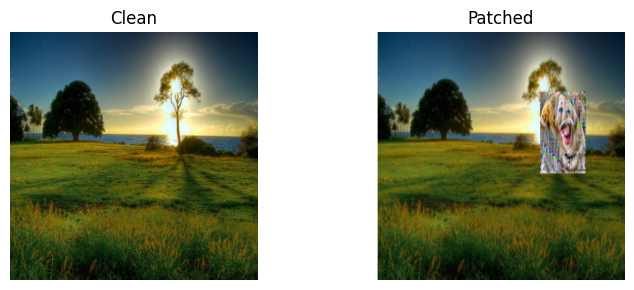

In [ ]:
def load_image_from_path(img_path: str) -> torch.Tensor:
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image not found: {img_path}")
    img = Image.open(img_path).convert("RGB")
    transform = T.Compose([
        T.Resize((336, 336)),
        T.ToTensor(),
    ])
    return transform(img)


clean_img_path  = "/content/drive/MyDrive/defense(for_patch_injection_attack)/data/images/nature.jpeg"
patch_img_path  = "/content/drive/MyDrive/defense(for_patch_injection_attack)/data/images/nature_patch.png"



clean_img  = load_image_from_path(clean_img_path)
patch_img  = load_image_from_path(patch_img_path)

print("Loaded clean image:", clean_img.shape)
print("Loaded patched image:", patch_img.shape)

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].imshow(clean_img.permute(1, 2, 0))
axs[0].set_title("Clean")
axs[0].axis("off")

axs[1].imshow(patch_img.permute(1, 2, 0))
axs[1].set_title("Patched")
axs[1].axis("off")

plt.tight_layout()
plt.show()


# Cell 3 — Generate random masks for multi-view defense

This function creates multiple masked versions of an input image.
Each copy receives two randomly placed black squares, which act as potential blockers of the adversarial patch.
The mask size is slightly larger than the known patch size to increasethe probability that at least one mask hides the patch.

The function returns an (n_copies x C x H x W) batch of masked images.


In [ ]:
#Cell 3:
import torch

def mask_two_random_masks_per_copy(
    img_tensor: torch.Tensor,
    n_copies: int = 30,
    patch_size: int = 124,
    enlarge: float = 1.4,      # mask slightly bigger than patch
    seed: int | None = 123,
) -> torch.Tensor:
    """
    Patch-agnostic masking:
      - Each copy gets 2 square masks, randomly placed anywhere in the image.
      - Mask size = patch_size * enlarge (slightly bigger than the patch).
      - No mask is forced to be at the center.

    This does NOT guarantee majority coverage with 10 copies, but with
    more copies and a moderate enlarge factor, the patch
    will be covered in many views with high probability.
    """
    assert img_tensor.ndim == 3 and img_tensor.shape[0] == 3
    C, H, W = img_tensor.shape
    device_img = img_tensor.device

    # compute mask size (clip to image)
    mask_size = int(patch_size * enlarge)
    mask_size = min(mask_size, H, W)

    masks_per_copy = 2
    mask_batch = torch.ones((n_copies, 1, H, W), device=device_img)

    # RNG for reproducibility
    g_cpu = None
    if seed is not None:
        g_cpu = torch.Generator(device="cpu")
        g_cpu.manual_seed(seed)

    for i in range(n_copies):
        for j in range(masks_per_copy):
            if g_cpu is not None:
                y0 = torch.randint(0, H - mask_size + 1, (1,), generator=g_cpu).item()
                x0 = torch.randint(0, W - mask_size + 1, (1,), generator=g_cpu).item()
            else:
                y0 = torch.randint(0, H - mask_size + 1, (1,)).item()
                x0 = torch.randint(0, W - mask_size + 1, (1,)).item()

            y1 = y0 + mask_size
            x1 = x0 + mask_size
            mask_batch[i, :, y0:y1, x0:x1] = 0.0

    img_batch = img_tensor.unsqueeze(0).expand(n_copies, -1, -1, -1)
    masks_3c = mask_batch.expand(-1, C, -1, -1)
    masked = img_batch * masks_3c
    return masked  # (n_copies, C, H, W)





# Cell 4 — Visualize masked image copies

This visualization function displays masked copies in a grid.
The purpose is to confirm that masks cover different areas of the image, producing a diverse set of masked views for the defense.


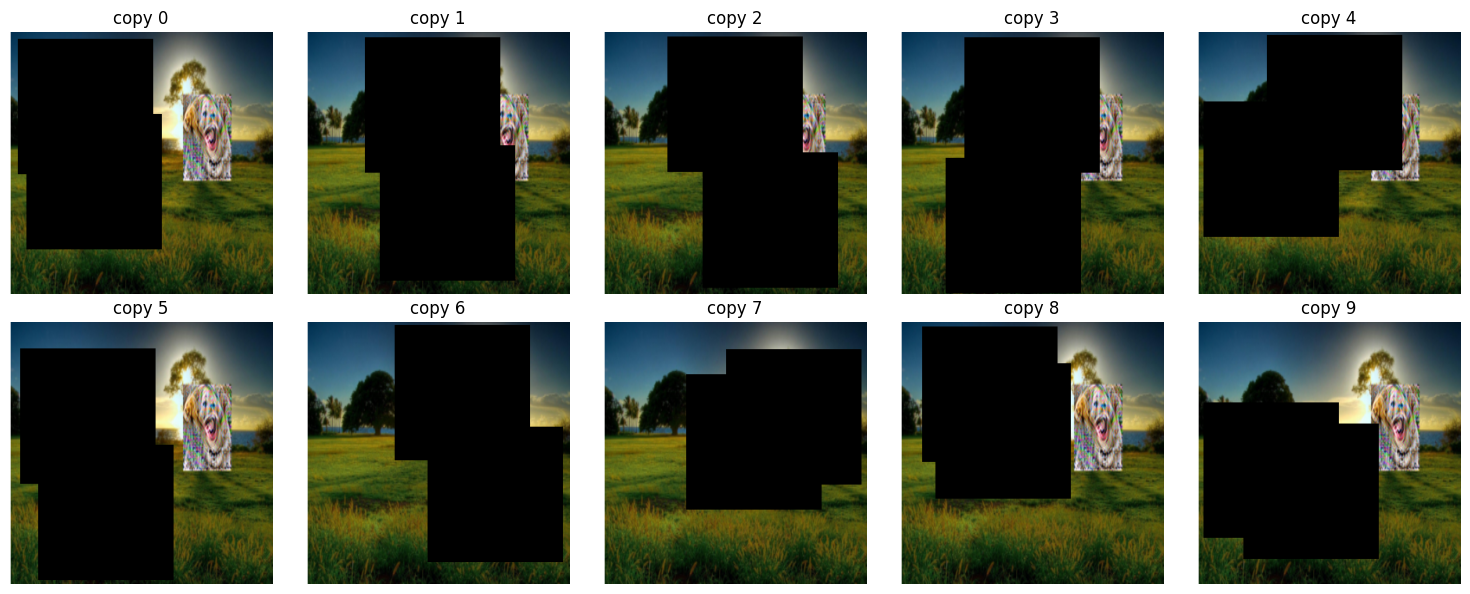

In [ ]:
#cell 4:

def show_masked_grid(img_tensor: torch.Tensor, n_copies: int = 10):
    img_dev = img_tensor.to(device)

    masked_batch = mask_two_random_masks_per_copy(
        img_dev,
        n_copies=n_copies,
        patch_size=124,
        enlarge=1.4,
        seed=123,
    ).cpu()

    cols = 5
    rows = (n_copies + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))

    axs = axs.flatten()
    for i in range(rows * cols):
        axs[i].axis("off")
        if i < n_copies:
            axs[i].imshow(masked_batch[i].permute(1, 2, 0))
            axs[i].set_title(f"copy {i}")

    plt.tight_layout()
    plt.show()

show_masked_grid(patch_img, n_copies=10)


# Cell 5 — Load LLaVA model and processor

This cell loads the LLaVA-1.5 7B HF model in 4-bit quantized format.
BitsAndBytesConfig reduces memory requirements so that the model fits on Colab GPUs.
The processor handles both text prompts and image preparation.
The model is set to evaluation mode.


In [ ]:
model_name = "llava-hf/llava-1.5-7b-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

processor = AutoProcessor.from_pretrained(model_name, use_fast=True)

model = LlavaForConditionalGeneration.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    dtype=torch.float16,
    device_map="auto",
)
model.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/674 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

LlavaForConditionalGeneration(
  (model): LlavaModel(
    (vision_tower): CLIPVisionModel(
      (vision_model): CLIPVisionTransformer(
        (embeddings): CLIPVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
          (position_embedding): Embedding(577, 1024)
        )
        (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (encoder): CLIPEncoder(
          (layers): ModuleList(
            (0-23): 24 x CLIPEncoderLayer(
              (self_attn): CLIPAttention(
                (k_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
                (v_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
                (q_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
                (out_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
              )
              (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affi

# Cell 6 — Build LLaVA prompt template

This helper function builds a system + user prompt using the default LLaVA chat template.
The prompt includes an <image> placeholder, which the processor replaces internally.


In [ ]:
def build_llava_prompt(question: str) -> str:
    """
    Build a chat-formatted prompt with an image placeholder,
    using the processor's chat template.
    """
    chat = [
        {
            "role": "system",
            "content": "You are a helpful vision-language assistant.",
        },
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": question},
            ],
        },
    ]

    prompt = processor.apply_chat_template(
        chat,
        tokenize=False,
        add_generation_prompt=True,
    )
    return prompt



# Cell 7 — Query LLaVA with an image and Baseline evaluation on clean vs patched images

ask_llava() sends a single image and question to the model.
The processor prepares the image + text, and the model generates a textual answer.
This function is used both for baseline evaluation and defense evaluation.

Also, this cell tests how LLaVA responds to:
1. The clean image (expected: correct description of the landscape)
2. The patched image (expected: dog-related description due to the adversarial patch)
This establishes the attack’s effectiveness before applying the defense.


In [ ]:
def ask_llava(img_tensor: torch.Tensor, question: str) -> str:
    # Convert tensor -> PIL
    img_pil = T.ToPILImage()(img_tensor.cpu())

    # Build text with <image> placeholder via chat template
    prompt = build_llava_prompt(question)

    # Processor handles both text and image together
    inputs = processor(
        text=prompt,
        images=img_pil,
        return_tensors="pt",
    ).to(device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=64,
        )

    # Decode only the generated part
    answer = processor.batch_decode(
        output_ids,
        skip_special_tokens=True,
    )[0]

    return answer


question = "Describe the scene in the image."

print("=== Baseline: Clean image ===")
print(ask_llava(clean_img, question))

print("\n=== Baseline: Patched image ===")
print(ask_llava(patch_img, question))


=== Baseline: Clean image ===
USER:  
Describe the scene in the image. ASSISTANT: The image features a beautiful scene of a sunset over a grassy field near the ocean. The sun is setting behind a tree, casting a warm glow over the landscape. The field is lush and green, providing a serene and picturesque setting for the sunset.

=== Baseline: Patched image ===
USER:  
Describe the scene in the image. ASSISTANT: The image features a dog with a blue tongue, standing in a grassy field near a body of water. The dog appears to be looking at the camera, possibly posing for a picture. The scene is set against a backdrop of a sunset, creating a beautiful and serene atmosphere.


# Cell 8- Full defense pipeline: masking + LLaVA inference + clustering

This function runs the full defense evaluation:

Step 1: Run baseline LLaVA inference on the clean image.

Step 2: Run baseline inference on the patched image (shows the attack effect).

Step 3: Apply multi-view masking to the patched image.
         Each masked image is sent through LLaVA independently.

Step 4: Collect all textual responses.

Step 5: Cluster the responses to determine the dominant semantic meaning.

The final output is the defended answer, representing the recovered semantics.


In [ ]:
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

def cluster_answers(answers, n_clusters=None):
    """
    Clustering-based majority voting for VLM answers.

    - No keyword heuristics (no cheating / no prior knowledge).
    - We cluster answers using TF-IDF cosine similarity.
    - Largest cluster represents the majority 'semantic' answer.

    If n_clusters is None, it will choose dynamically based on number of answers.
    """

    if len(answers) == 0:
        return None, None, None

    # vectorize
    vect = TfidfVectorizer(stop_words="english")
    X = vect.fit_transform(answers)

    # simple dynamic number of clusters
    if n_clusters is None:
        n_clusters = max(2, min(10, len(answers)//2))

    # KMeans
    from sklearn.cluster import KMeans
    km = KMeans(n_clusters=n_clusters, random_state=0)
    labels = km.fit_predict(X)

    # find largest cluster
    counts = Counter(labels)
    majority_label, majority_size = counts.most_common(1)[0]

    # extract all answers in this cluster
    cluster_answers = [answers[i] for i in range(len(answers)) if labels[i] == majority_label]

    # pick representative answer (first one in cluster)
    defended_answer = cluster_answers[0]

    return defended_answer, majority_label, counts


def defense_multiview_answer(
    clean_tensor: torch.Tensor,
    patched_tensor: torch.Tensor,
    question: str,
    n_copies: int = 10,
    grid_sizes: tuple[int, ...] = (2,),
    verbose: bool = True,
):
    """
    Full evaluation pipeline:

    1. Baseline on CLEAN (no patch, no mask)
    2. Baseline on PATCHED (patch, no mask)
    3. Defense on PATCHED (patch + sliding-window masking + clustering)
    """

    # -----------------------------------------
    # 1️⃣ BASELINE: CLEAN IMAGE (NO MASKING)
    # -----------------------------------------
    print("\n=== Baseline on CLEAN image (no defense) ===")
    clean_ans = ask_llava(clean_tensor.to(device), question)
    print(clean_ans)

    # -----------------------------------------
    # 2️⃣ BASELINE: PATCHED IMAGE (NO MASKING)
    # -----------------------------------------
    print("\n=== Baseline on PATCHED image (no defense) ===")
    patched_base_ans = ask_llava(patched_tensor.to(device), question)
    print(patched_base_ans)

    # -----------------------------------------
    # 3️⃣ DEFENSE: MULTI-VIEW MASKING ON PATCHED
    # -----------------------------------------
    patched_dev = patched_tensor.to(device)

    masked_batch = mask_multiscale_covering(
        patched_dev,
        n_copies=n_copies,
        grid_sizes=grid_sizes,
        seed=123,
    )

    answers = []

    for i in range(n_copies):
        if verbose:
            print(f"\n----- Masked Copy {i+1}/{n_copies} -----")

        ans = ask_llava(masked_batch[i], question)
        answers.append(ans)

        if verbose:
            print("Answer:", ans)

    if verbose:
        print("\n===== DEFENSE RESULT: PATCHED IMAGE =====")

    # -----------------------------------------
    # Clustering-based semantic majority
    # -----------------------------------------
    defended_answer, majority_label, counts = cluster_answers(answers)

    if verbose:
        print("Cluster label counts :", counts)
        print("Chosen cluster       :", majority_label)
        print("Defended answer      :", defended_answer)

    return {
        "clean": clean_ans,
        "patched_no_defense": patched_base_ans,
        "masked_answers": answers,
        "defended_answer": defended_answer,
        "cluster_counts": counts,
        "majority_cluster": majority_label,
    }


# -----------------------------------------
#  Example call (
# -----------------------------------------
result = defense_multiview_answer(
    clean_img,
    patch_img,
    question="Describe the scene in the image.",
    n_copies=10,
    grid_sizes=(2,),
    verbose=True,
)



=== Baseline on CLEAN image (no defense) ===
USER:  
Describe the scene in the image. ASSISTANT: The image features a beautiful scene of a sunset over a grassy field near the ocean. The sun is setting behind a tree, casting a warm glow over the landscape. The field is lush and green, providing a serene and picturesque setting for the sunset.

=== Baseline on PATCHED image (no defense) ===
USER:  
Describe the scene in the image. ASSISTANT: The image features a dog with a blue tongue, standing in a grassy field near a body of water. The dog appears to be looking at the camera, possibly posing for a picture. The scene is set against a backdrop of a sunset, creating a beautiful and serene atmosphere.

----- Masked Copy 1/10 -----
Answer: USER:  
Describe the scene in the image. ASSISTANT: The image features a lush green field with a large, colorful, and patterned tapestry or blanket hanging in the middle of the scene. The tapestry is positioned in such a way that it appears to be floatin